# Matching Market

This simple model consists of a buyer, a supplier, and a market. 

The buyer represents a group of customers whose willingness to pay for a single unit of the good is captured by a vector of prices _wta_. You can initiate the buyer with a set_quantity function which randomly assigns the willingness to pay according to your specifications. You may ask for these willingness to pay quantities with a _getbid_ function. 

The supplier is similar, but instead the supplier is willing to be paid to sell a unit of technology. The supplier for instance may have non-zero variable costs that make them unwilling to produce the good unless they receive a specified price. Similarly the supplier has a  get_ask function which returns a list of desired prices. 

The willingness to pay or sell are set randomly using uniform random distributions. The resultant lists of bids are effectively a demand curve. Likewise the list of asks is effectively a supply curve. A more complex determination of bids and asks is possible, for instance using time of year to vary the quantities being demanded. 

## New in version 20
- fixed bug in clearing mechanism, included a logic check to avoid wierd behavior around zero

## Microeconomic Foundations

The market assumes the presence of an auctioneer which will create a _book_, which seeks to match the bids and the asks as much as possible. If the auctioneer is neutral, then it is incentive compatible for the buyer and the supplier to truthfully announce their bids and asks. The auctioneer will find a single price which clears as much of the market as possible. Clearing the market means that as many willing swaps happens as possible. You may ask the market object at what price the market clears with the get_clearing_price function. You may also ask the market how many units were exchanged with the get_units_cleared function.

## Agent-Based Objects

The following section presents three objects which can be used to make an agent-based model of an efficient, two-sided market.

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import random as rnd
import pandas as pd
import numpy as np
import time
import datetime
import calendar
import json
import statistics

# fix what is missing with the datetime/time/calendar package
def add_months(sourcedate,months):
    month = sourcedate.month - 1 + months
    year = int(sourcedate.year + month / 12 )
    month = month % 12 + 1
    day = min(sourcedate.day,calendar.monthrange(year, month)[1])
    return datetime.date(year,month,day)

# measure how long it takes to run the script
startit = time.time()
dtstartit = datetime.datetime.now()

## classes buyers and sellers
Below we are constructing the buyers and sellers in classes.

In [9]:
class Seller():
    def __init__(self, name):
        self.name = name
        self.wta = []
        self.step = 0
        self.prod = 2000
        self.lb_price = 10
        self.lb_multiplier = 0
        self.ub_price = 20
        self.ub_multiplier = 0
        self.init_reserve = 500000
        self.reserve = 500000
        self.init_unproven_reserve = 0
        self.unproven_reserve = 0
        #multiple market idea, also 'go away from market'
        self.subscr_market = {}
        self.last_price = 15
        self.state_hist = {}
        self.cur_scenario = ''
        self.count = 0
        self.storage = 0
        self.q_to_market = 0
        self.ratio_sold = 0
        self.ratio_sold_hist = []

    # the supplier has n quantities that they can sell
    # they may be willing to sell this quantity anywhere from a lower price of l
    # to a higher price of u
    def set_quantity(self):
        self.count = 0
        self.update_price()
        n = self.prod
        l = self.lb_price + self.lb_multiplier
        u = self.ub_price + self.ub_multiplier
        wta = []
        for i in range(n):
            p = rnd.uniform(l, u)
            wta.append(p)
        if len(wta) < self.reserve:
            self.wta = wta
        else:
            self.wta = wta[0:(self.reserve-1)]
            self.prod = self.reserve
        if len(self.wta) > 0:
            self.wta = self.wta #sorted(self.wta, reverse=False)
        self.q_to_market = len(self.wta)
        
        
    def get_name(self):
        return self.name

    def get_asks(self):
        return self.wta

    def extract(self, cur_extraction):
        if self.reserve > 0:
            self.reserve = self.reserve - cur_extraction
        else:
            self.prod = 0

    # production costs rise a 100% 
    def update_price(self):
        depletion = (self.init_reserve - self.reserve) / self.init_reserve
        self.ub_multiplier = int(self.ub_price * depletion)
        self.lb_multiplier = int(self.lb_price * depletion)
        
    def return_not_cleared(self, not_cleared):
        self.count = self.count + (len(self.wta) - len(not_cleared))
        self.wta = not_cleared

    def get_price(self, price):
        self.last_price = price
        
    def update_production(self):
        if (self.step/12).is_integer():
            if self.prod > 0 and self.q_to_market > 0:
                rp_ratio = self.reserve / self.prod
                self.ratio_sold = self.count / self.q_to_market
                self.ratio_sold_hist.append(self.ratio_sold)
                yearly_average = statistics.mean(self.ratio_sold_hist[-12:])
                if (rp_ratio > 15) and (yearly_average > Yearly_average_treshold):
                    self.prod = int(self.prod * 1.1)
                    if print_details:
                        print("%s evaluate production" % self.name)
                if (self.unproven_reserve > 0) and (self.cur_scenario == 'PACES'):
                    self.reserve = self.reserve + int(0.1 * self.init_unproven_reserve)
                    self.unproven_reserve = self.unproven_reserve - int(0.1 * self.init_unproven_reserve)
                    
    def evaluate_timestep(self):
        self.update_production()

    # record every step into an dictionary, nog pythonic look into (vars)
    def book_keeping(self):
        self.state_hist[self.step] = self.__dict__

        
class Buyer():
    def __init__(self, name):
        self.name = name
        self.type = 0
        self.rof = 0
        self.wtp = []
        self.step = 0
        self.offset= 0
        self.base_demand = 0
        self.max_demand = 0
        self.lb_price = 10
        self.ub_price = 20
        self.last_price = 15
        self.subscr_market = {}
        self.state_hist = {}
        self.cur_scenario = ''
        self.count = 0
        self.real_demand = 0
        self.storage_cap = 1
        self.storage = 0
        self.storage_q = 0

    # the supplier has n quantities that they can buy
    # they may be willing to sell this quantity anywhere from a lower price of l
    # to a higher price of u
    def set_quantity(self):
        self.count = 0
        self.update_price()
        n = int(self.consumption(self.step))
        l = self.lb_price
        u = self.ub_price
        wtp = []
        for i in range(n):
            p = rnd.uniform(l, u)
            wtp.append(p)
        self.wtp = wtp #sorted(wtp, reverse=True)
        
    # gets a little to obvious
    def get_name(self):
        return self.name
    
    # return list of willingness to pay
    def get_bids(self):
        return self.wtp
    
    def consumption(self, x):
        # make it initialise to seller
        b = self.base_demand
        m = self.max_demand
        y = b + m * (.5 * (1 + np.cos(((x+self.offset)/6)*np.pi)))
        self.real_demand = y
        s = self.storage_manager()
        return(y+s)
    
    def update_price(self):
        # adjust Q
        if self.type == 1: #home
            if (self.step/12).is_integer():
                self.base_demand = home_savings[self.cur_scenario] * self.base_demand
                self.max_demand = home_savings[self.cur_scenario] * self.max_demand
        if self.type == 2: # elec for eu + us
            if (self.step/12).is_integer():
                cur_elec_df = elec_space['RELATIVE'][self.cur_scenario]
                period_now = add_months(period_null, self.step)
                index_year = int(period_now.strftime('%Y'))
                #change_in_demand = cur_elec_df[index_year]
                self.base_demand = self.base_demand * cur_elec_df[index_year]
                self.max_demand = self.max_demand * cur_elec_df[index_year]
        if self.type == 3: #indu
            if (self.step/12).is_integer():
                if (self.rof == 0) and (self.cur_scenario == 'PACES'):
                    #cur_df = economic_growth['ECONOMIC GROWTH'][self.cur_scenario]
                    period_now = add_months(period_null, self.step)
                    index_year = int(period_now.strftime('%Y'))
                    #growth = cur_df[index_year]
                    growth = np.arctan((index_year-2013)/10)/(.5*np.pi)*.05+0.03
                    self.base_demand = (1 + growth) * self.base_demand
                    self.max_demand = (1 + growth) * self.max_demand
                else:
                    cur_df = economic_growth['ECONOMIC GROWTH'][self.cur_scenario]
                    period_now = add_months(period_null, self.step)
                    index_year = int(period_now.strftime('%Y'))
                    growth = cur_df[index_year]
                    self.base_demand = (1 + growth) * self.base_demand
                    self.max_demand = (1 + growth) * self.max_demand
                    
        ## adjust P now to get_price, but adress later
        ## moved to get_price, rename update_price function (?)
        #self.lb_price = self.last_price * .75
        #self.ub_price= self.last_price * 1.25

    def return_not_cleared(self, not_cleared):
        self.count = self.count + (len(self.wtp)-len(not_cleared))
        self.wtp = not_cleared

    def get_price(self, price):
        self.last_price = price
        if self.last_price > 100:
            self.last_price = 100
        self.lb_price = self.last_price * .75
        self.ub_price= self.last_price * 1.25
    
    # writes complete state to a dictionary, see if usefull
    def book_keeping(self):
        self.state_hist[self.step] = self.__dict__
        
    # there has to be some accountability for uncleared bids of the buyers
    def evaluate_timestep(self):
        if self.type==1:
            not_cleared = len(self.wtp)
            #total_demand = self.real_demand + self.storage_q
            storage_delta = self.storage_q - not_cleared
            self.storage = self.storage + storage_delta
            if print_details:
                print(self.name, storage_delta)

    def storage_manager(self):
        # check if buyer is household buyer
        if self.type==1:
            if self.storage < 0:
                self.storage_q = -self.storage
            else:
                self.storage_q = 0
            return(self.storage_q)
        else:
            return(0)


## Construct the market
For the market two classes are made. The market itself, which controls the buyers and the sellers, and the book. The market has a book where the results of the clearing procedure are stored.

In [10]:
# the book is an object of the market used for the clearing procedure
class Book():
    def __init__(self):
        self.ledger = pd.DataFrame(columns = ("role","name","price","cleared"))

    def set_asks(self,seller_list):
        # ask each seller their name
        # ask each seller their willingness
        # for each willingness append the data frame
        for seller in seller_list:
            seller_name = seller.get_name()
            seller_price = seller.get_asks()
            ar_role = np.full((1,len(seller_price)),'seller', dtype=object)
            ar_name = np.full((1,len(seller_price)),seller_name, dtype=object)
            ar_cleared = np.full((1,len(seller_price)),'in process', dtype=object)
            temp_ledger = pd.DataFrame([*ar_role,*ar_name,seller_price,*ar_cleared]).T
            temp_ledger.columns= ["role","name","price","cleared"]
            self.ledger = self.ledger.append(temp_ledger, ignore_index=True)

    def set_bids(self,buyer_list):
        # ask each seller their name
        # ask each seller their willingness
        # for each willingness append the data frame
        for buyer in buyer_list:
            buyer_name = buyer.get_name()
            buyer_price = buyer.get_bids()
            ar_role = np.full((1,len(buyer_price)),'buyer', dtype=object)
            ar_name = np.full((1,len(buyer_price)),buyer_name, dtype=object)
            ar_cleared = np.full((1,len(buyer_price)),'in process', dtype=object)
            temp_ledger = pd.DataFrame([*ar_role,*ar_name,buyer_price,*ar_cleared]).T
            temp_ledger.columns= ["role","name","price","cleared"]
            self.ledger = self.ledger.append(temp_ledger, ignore_index=True)
            
    def update_ledger(self,ledger):
        self.ledger = ledger
        
    def get_ledger(self):
        return self.ledger
    
    def clean_ledger(self):
        self.ledger = pd.DataFrame(columns = ("role","name","price","cleared"))

class Market():
    def __init__(self, name):
        self.name= name
        self.count = 0
        self.last_price = ''
        self.book = Book()
        self.b = []
        self.s = []
        self.buyer_list = []
        self.seller_list = []
        self.buyer_dict = {}
        self.seller_dict = {}
        self.ledger = ''
        self.seller_analytics = {}
        self.buyer_analytics = {}

            
    def book_keeping_all(self):
        for i in self.buyer_dict:
            self.buyer_dict[i].book_keeping()
        for i in self.seller_dict:
            self.seller_dict[i].book_keeping()
    
    
    def add_buyer(self,buyer):
        if buyer.subscr_market[self.name] == 1:
            self.buyer_list.append(buyer)
        
        
    def add_seller(self,seller):
        if seller.subscr_market[self.name] == 1:       
            self.seller_list.append(seller)
        
        
    def set_book(self):
        self.book.set_bids(self.buyer_list)
        self.book.set_asks(self.seller_list)
        
        
    def get_bids(self):
        # this is a data frame
        ledger = self.book.get_ledger()
        rows= ledger.loc[ledger['role'] == 'buyer']
        # this is a series
        prices=rows['price']
        # this is a list
        bids = prices.tolist()
        return bids
    
    
    def get_asks(self):
        # this is a data frame
        ledger = self.book.get_ledger()
        rows = ledger.loc[ledger['role'] == 'seller']
        # this is a series
        prices=rows['price']
        # this is a list
        asks = prices.tolist()
        return asks
    
    # return the price at which the market clears
    # this fails because there are more buyers then sellers
    
    
    def get_clearing_price(self):
        # buyer makes a bid starting with the buyer which wants it most
        b = self.get_bids()
        s = self.get_asks()
        # highest to lowest
        self.b=sorted(b, reverse=True)
        # lowest to highest
        self.s=sorted(s, reverse=False)
        
        # find out whether there are more buyers or sellers
        # then drop the excess buyers or sellers; they won't compete
        n = len(b)
        m = len(s)
        
        # there are more sellers than buyers
        # drop off the highest priced sellers 
        if (m > n):
            s = s[0:n]
            matcher = n
        # There are more buyers than sellers
        # drop off the lowest bidding buyers 
        else:
            b = b[0:m]
            matcher = m
        
        # -It's possible that not all items sold actually clear the market here
        # -Produces an error when one of the two lists are empty
        #  something like 'can't compare string and float'
        count = 0
        for i in range(matcher):
            if (self.b[i] > self.s[i]):
                count +=1
                self.last_price = self.b[i]
        
        # copy count to market object
        self.count = count
        return self.last_price
    
    
    # TODO: Annotate the ledger
    # this procedure takes up 80% of processing time
    def annotate_ledger(self,clearing_price):
        ledger = self.book.get_ledger()
        
        # logic test
        # b or s can not be zero, probably error or unreliable results
        # so annote everything as false in that case and move on
        b = self.get_bids()
        s = self.get_asks()
        if (len(s)==0 or len(b)==0):
            new_col = [ 'False' for i in range(len(ledger['cleared']))]
            ledger['cleared'] = new_col
                
            self.book.update_ledger(ledger)
            
            return
        # end logic test
        
        for index, row in ledger.iterrows():
            if (row['role'] == 'seller'):
                if (row['price'] < clearing_price):
                    ledger.loc[index,'cleared'] = 'True'
                else:
                    ledger.loc[index,'cleared'] = 'False'
            else:
                if (row['price'] > clearing_price):
                    ledger.loc[index,'cleared'] = 'True'
                else:
                    ledger.loc[index,'cleared'] = 'False'  
                    
        self.book.update_ledger(ledger)
    
    
    def get_units_cleared(self):
        return self.count
    
    
    def clean_ledger(self):
        self.ledger = ''
        self.book.clean_ledger()

        
    def run_it(self):
        self.pre_clearing_operation()
        self.clearing_operation()
        self.after_clearing_operation()
        
        
        # pre clearing empty out the last run and start
        # clean ledger is kind of sloppy, rewrite functions to overide the ledger
    def pre_clearing_operation(self):
        self.clean_ledger()
        
        
    def clearing_operation(self):
        self.set_book()
        clearing_price = self.get_clearing_price()
        if print_details:
            print(self.name, clearing_price)
        self.annotate_ledger(clearing_price)
        
        
    def after_clearing_operation(self):
        for agent in self.seller_list:
            name = agent.name
            cur_extract = len(self.book.ledger[(self.book.ledger['cleared'] == 'True') &
                                               (self.book.ledger['name'] == name)])
            agent.extract(cur_extract)
            agent.get_price(self.last_price)
            self.seller_analytics[name] = cur_extract
            if cur_extract >0:
                agent_asks = agent.get_asks()
                agent_asks = sorted(agent_asks, reverse=False)
                not_cleared = agent_asks[cur_extract:len(agent_asks)]
                agent.return_not_cleared(not_cleared)
 
        for agent in self.buyer_list:
            name = agent.name
            cur_extract = len(self.book.ledger[(self.book.ledger['cleared'] == 'True') &
                                               (self.book.ledger['name'] == name)])
            agent.get_price(self.last_price)
            self.buyer_analytics[name] = cur_extract  
            if cur_extract >0:
                agent_bids = agent.get_bids()
                agent_bids = sorted(agent_bids, reverse=True)
                not_cleared = agent_bids[cur_extract:len(agent_bids)]
                agent.return_not_cleared(not_cleared)
 
                
        # cleaning up the books
        self.book_keeping_all()


## Observer
The observer holds the clock and collects data. In this setup it tells the market another tick has past and it is time to act. The market will instruct the other agents. The observer initializes the model, thereby making real objects out of the classes defined above.

In [11]:
class Observer():
    def __init__(self, init_buyer, init_seller, timesteps, scenario):
        self.init_buyer = init_buyer
        self.init_seller = init_seller
        self.init_market = init_market
        self.maxrun = timesteps
        self.cur_scenario = scenario
        self.buyer_dict = {}
        self.seller_dict = {}
        self.market_dict = {}
        self.timetick = 0
        self.gas_market = ''
        self.market_hist = []
        self.seller_hist = []
        self.buyer_hist = []
        self.market_origin = []
        self.market_origin_df = pd.DataFrame(columns=['seller_analytics','buyer_analytics'])
        self.all_data = {}

    def set_buyer(self, buyer_info):
        for name in buyer_info:
            self.buyer_dict[name] = Buyer('%s' % name)
            self.buyer_dict[name].base_demand = buyer_info[name]['offset']
            self.buyer_dict[name].base_demand = buyer_info[name]['b']
            self.buyer_dict[name].max_demand = buyer_info[name]['m']
            self.buyer_dict[name].lb_price = buyer_info[name]['lb_price']
            self.buyer_dict[name].ub_price = buyer_info[name]['ub_price']
            self.buyer_dict[name].type = buyer_info[name]['type']
            self.buyer_dict[name].rof = buyer_info[name]['rof']
            self.buyer_dict[name].cur_scenario = self.cur_scenario
            self.buyer_dict[name].subscr_market = dict.fromkeys(init_market,0)
            for market in buyer_info[name]['market']:
                self.buyer_dict[name].subscr_market[market] = 1

    def set_seller(self, seller_info):
        for name in seller_info:
            self.seller_dict[name] = Seller('%s' % name)
            self.seller_dict[name].prod = seller_info[name]['prod']
            self.seller_dict[name].lb_price = seller_info[name]['lb_price']
            self.seller_dict[name].ub_price = seller_info[name]['ub_price']
            self.seller_dict[name].reserve = seller_info[name]['reserve']
            self.seller_dict[name].init_reserve = seller_info[name]['reserve']
            self.seller_dict[name].unproven_reserve = seller_info[name]['UP_reserve']
            self.seller_dict[name].init_unproven_reserve = seller_info[name]['UP_reserve']
            #self.seller_dict[name].rof = seller_info[name]['rof']
            self.seller_dict[name].cur_scenario = self.cur_scenario
            self.seller_dict[name].subscr_market = dict.fromkeys(init_market,0)
            for market in seller_info[name]['market']:
                self.seller_dict[name].subscr_market[market] = 1
    
    def set_market(self, market_info):
        for name in market_info:
            self.market_dict[name] = Market('%s' % name)
        #add suplliers and buyers to this market
            for supplier in self.seller_dict.values():
                self.market_dict[name].add_seller(supplier)
            for buyer in self.buyer_dict.values():
                self.market_dict[name].add_buyer(buyer)
            self.market_dict[name].seller_dict = self.seller_dict
            self.market_dict[name].buyer_dict = self.buyer_dict
    
    def update_buyer(self):
        for i in self.buyer_dict:
            self.buyer_dict[i].step += 1
            self.buyer_dict[i].set_quantity()
    
    def update_seller(self):
        for i in self.seller_dict:
            self.seller_dict[i].step += 1
            self.seller_dict[i].set_quantity()

    def evaluate_timestep(self):
        for i in self.buyer_dict:
            self.buyer_dict[i].evaluate_timestep()
        for i in self.seller_dict:
            self.seller_dict[i].evaluate_timestep()

    def get_reserve(self):
        reserve = []
        for name in self.seller_dict:
            reserve.append(self.seller_dict[name].reserve)
        return reserve            

    def get_data(self):
        for name in self.seller_dict:
            self.all_data[name] = self.seller_dict[name].state_hist
        for name in self.buyer_dict:
            self.all_data[name] = self.buyer_dict[name].state_hist

    def run_it(self):
        # Timing
        # time initialising
        startit_init = time.time()
        
        # initialise, setting up all the agents (firstrun not really needed anymore, since outside the loop)
        # might become useful again if run_it is used for parametersweep
        first_run = True
        if first_run:
            self.set_buyer(self.init_buyer)
            self.set_seller(self.init_seller)
            self.set_market(self.init_market)
            first_run=False
            
        # time init stop
        stopit_init = time.time() - startit_init
        if print_details:
            print('%s : initialisation time' % stopit_init)
        
        # building the multiindex for origin dataframe
        listing = []
        for m in self.market_dict:
            listing_buyer = [(runname, m,'buyer_analytics',v.name) for v in self.market_dict[m].buyer_list]
            listing = listing + listing_buyer
            listing_seller = [(runname, m,'seller_analytics',v.name) for v in self.market_dict[m].seller_list]
            listing = listing + listing_seller
        multi_listing = pd.MultiIndex.from_tuples(listing)
        # recording everything in dataframes, more dependable than lists?
        
        #reserve_df = pd.DataFrame(data=None, columns=[i for i in self.seller_dict])
        #iterables = [[i for i in self.market_dict], ['buyer_analytics', 'seller_analytics']]
        #index = pd.MultiIndex.from_product(iterables)
        market_origin_df = pd.DataFrame(data=None, columns=multi_listing)
        

        for period in range(self.maxrun):
            # time the period
            startit_period = time.time()

            self.timetick += 1
            period_now = add_months(period_null, self.timetick-1)
            if print_details:
                print('#######################################')
                print(period_now.strftime('%Y-%b'), self.cur_scenario)
            
            # update the buyers and sellers (timetick+ set Q)
            self.update_buyer()
            self.update_seller()
            
            # real action on the market
            for market in self.market_dict:
                if market != 'lng':
                    self.market_dict[market].run_it()
            self.market_dict['lng'].run_it()

            #tell buyers timetick has past
            self.evaluate_timestep()
                

            # data collection
            for name in self.market_dict:
                p_clearing = self.market_dict[name].last_price
                q_sold = self.market_dict[name].count
                self.market_hist.append([period_now.strftime('%Y-%b'), p_clearing, q_sold, name])
            
            for name in self.seller_dict:
                reserve = self.seller_dict[name].reserve
                produced = self.seller_dict[name].count
                self.seller_hist.append([period_now.strftime('%Y-%b'), reserve, produced, name])
                
            for name in self.buyer_dict:
                storage = self.buyer_dict[name].storage
                consumed = self.buyer_dict[name].count
                self.buyer_hist.append([period_now.strftime('%Y-%b'), storage, consumed, name])
            
            # means to caption the origin of stuff sold on the market,
            # but since dictionaries are declared global of some sort
            # Dataframe has to be used to capture the real values
            for name in self.market_dict:
                seller_analytics = self.market_dict[name].seller_analytics
                buyer_analytics = self.market_dict[name].buyer_analytics
                for seller in seller_analytics:
                    market_origin_df.loc[period_now.strftime('%Y-%b'),
                                         (runname, name,'seller_analytics',seller)] = seller_analytics[seller]
                for buyer in buyer_analytics:
                    market_origin_df.loc[period_now.strftime('%Y-%b'),
                                         (runname, name,'buyer_analytics',buyer)] = buyer_analytics[buyer]

            # recording the step_info
            # since this operation can take quite a while, print after every operation
            period_time = time.time() - startit_period
            if print_details:
                print('%.2f : seconds to clear period' % period_time)
        #safe df as attribute
        self.market_origin_df = market_origin_df

## Example Market

In the following code example we use the buyer and supplier objects to create a market. At the market a single price is announced which causes as many units of goods to be swapped as possible. The buyers and sellers stop trading when it is no longer in their own interest to continue. 

In [12]:
# import scenarios
inputfile = 'economic growth scenarios.xlsx'
# economic growth percentages
economic_growth = pd.read_excel(inputfile, sheetname='ec_growth', index_col=0, header=[0,1])

## demand for electricity import scenarios spaced by excel
#elec_space = pd.read_excel(inputfile, sheetname='elec_space', skiprows=1, index_col=0, header=0)

# demand for electricity import scenarios spaced by excel
elec_space = pd.read_excel(inputfile, sheetname='elec_space', index_col=0, header=[0,1])

# gasdemand home (percentage increases)
home_savings = {'PACES': 1.01, 'TIDES': .99, 'CIRCLES': .97}

# multilevel ecgrowth
economic_growth2 = pd.read_excel(inputfile, sheetname='ec_growth', index_col=0, header=[0,1])

#economic_growth2['ECONOMIC GROWTH']

C:\Anaconda3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [13]:
# reading excel initialization data back
read_file = 'init_buyers_sellers_lng.xlsx'
df_buyer = pd.read_excel(read_file,orient='index',sheetname='buyers')
df_seller = pd.read_excel(read_file,orient='index',sheetname='sellers')
df_buyer['market'] = [eval(i) for i in df_buyer['market'].values]
df_seller['market'] = [eval(i) for i in df_seller['market'].values]
init_buyer = df_buyer.to_dict('index')
init_seller = df_seller.to_dict('index')

#init_market = {'eu', 'us','as'}, construct markets by unique values
market = []
for i in init_seller:
    for x in init_seller[i]['market']: market.append(x)
for i in init_buyer:
    for x in init_buyer[i]['market']: market.append(x)
market = list(set(market))
init_market = market

# set the starting time
period_null= datetime.date(2013,1,1)

C:\Anaconda3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


## run the model
To run the model we create the observer. The observer creates all the other objects and runs the model.

In [14]:
# create observer and run the model
# first data about buyers then sellers and then model ticks
years = 35
# timestep = 12
print_details = False
run_market = {}
run_seller = {}
run_buyer = {}
run_market_origin_df = {}
yat_list = np.arange(.5, 1, .05)
for i in range(10):
    Yearly_average_treshold = yat_list[i]
    scen = 'TIDES'
    runname = '%s_%s' %(i,scen)
    dtrunstart = datetime.datetime.now()
    print('\n%s scenario %d year run started' %(i,years))
    obser1 = Observer(init_buyer, init_seller, years*12, scen)
    obser1.run_it()
    #get the info from the observer
    run_market[runname] = obser1.market_hist
    run_seller[runname] = obser1.seller_hist
    run_buyer[runname] = obser1.buyer_hist
    run_market_origin_df[runname] = obser1.market_origin_df
    #run_data[i] = obser1.all_data
    dtrunstop = datetime.datetime.now()
    print('%s scenario %d year run finished' %(i,years))
    print('this run took %s (h:m:s) to complete'% (dtrunstop - dtrunstart))


0 scenario 35 year run started
0 scenario 35 year run finished
this run took 1:36:39.748071 (h:m:s) to complete

1 scenario 35 year run started
1 scenario 35 year run finished
this run took 1:18:57.145345 (h:m:s) to complete

2 scenario 35 year run started
2 scenario 35 year run finished
this run took 1:15:34.129372 (h:m:s) to complete

3 scenario 35 year run started
3 scenario 35 year run finished
this run took 1:08:56.041772 (h:m:s) to complete

4 scenario 35 year run started
4 scenario 35 year run finished
this run took 1:01:10.994537 (h:m:s) to complete

5 scenario 35 year run started
5 scenario 35 year run finished
this run took 0:56:57.035714 (h:m:s) to complete

6 scenario 35 year run started
6 scenario 35 year run finished
this run took 0:50:04.930086 (h:m:s) to complete

7 scenario 35 year run started
7 scenario 35 year run finished
this run took 0:46:22.511200 (h:m:s) to complete

8 scenario 35 year run started
8 scenario 35 year run finished
this run took 0:44:25.941189 (h:

In [15]:
# timeit

stopit = time.time()
dtstopit = datetime.datetime.now()

print('it took us %s seconds to get to this conclusion' % (stopit-startit))
print('in another notation (h:m:s) %s'% (dtstopit - dtstartit))

it took us 37111.96407079697 seconds to get to this conclusion
in another notation (h:m:s) 10:18:31.964071


## Operations Research Formulation

The market can also be formulated as a very simple linear program or linear complementarity problem. It is clearer and easier to implement this market clearing mechanism with agents. One merit of the agent-based approach is that we don't need linear or linearizable supply and demand function. 

The auctioneer is effectively following a very simple linear program subject to constraints on units sold. The auctioneer is, in the primal model, maximizing the consumer utility received by customers, with respect to the price being paid, subject to a fixed supply curve. On the dual side the auctioneer is minimizing the cost of production for the supplier, with respect to quantity sold, subject to a fixed demand curve. It is the presumed neutrality of the auctioneer which justifies the honest statement of supply and demand. 

An alternative formulation is a linear complementarity problem. Here the presence of an optimal space of trades ensures that there is a Pareto optimal front of possible trades. The perfect opposition of interests in dividing the consumer and producer surplus means that this is a zero sum game. Furthermore the solution to this zero-sum game maximizes societal welfare and is therefore the Hicks optimal solution.

## Next Steps

A possible addition of this model would be to have a weekly varying demand of customers, for instance caused by the use of natural gas as a heating agent. This would require the bids and asks to be time varying, and for the market to be run over successive time periods. A second addition would be to create transport costs, or enable intermediate goods to be produced. This would need a more elaborate market operator.  Another possible addition would be to add a profit maximizing broker. This may require adding belief, fictitious play, or message passing. 

The object-orientation of the models will probably need to be further rationalized. Right now the market requires very particular ordering of calls to function correctly. 

## Time of last run
Time and date of the last run of this notebook file 

In [16]:
# print the time of last run
print('last run of this notebook:')
time.strftime("%a, %d %b %Y %H:%M:%S", time.localtime())

last run of this notebook:


'Tue, 06 Feb 2018 00:45:02'

## Plotting scenario runs
For the scenario runs we vary the external factors according to the scenarios. Real plotting is done in a seperate visualization file

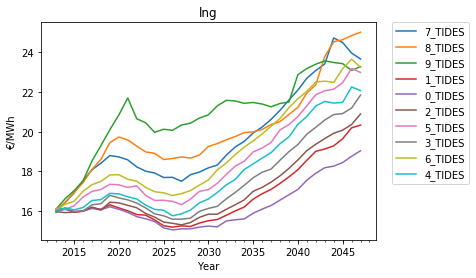

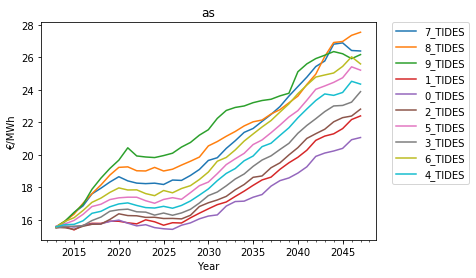

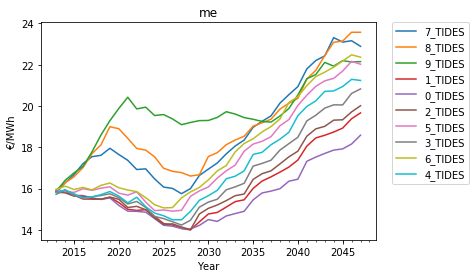

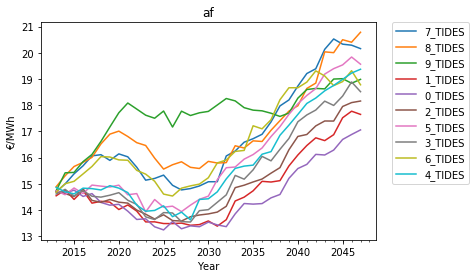

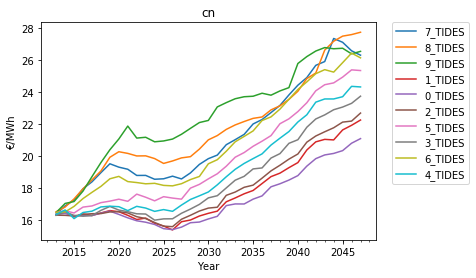

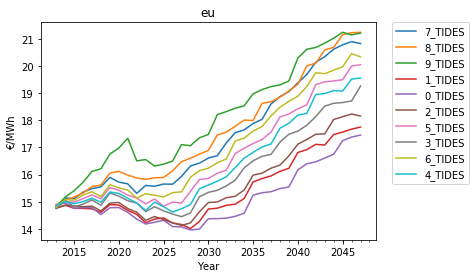

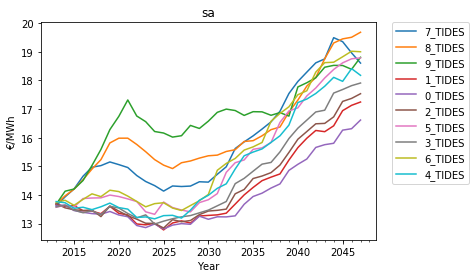

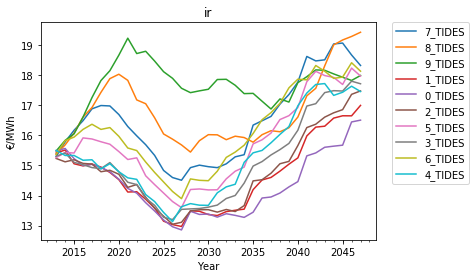

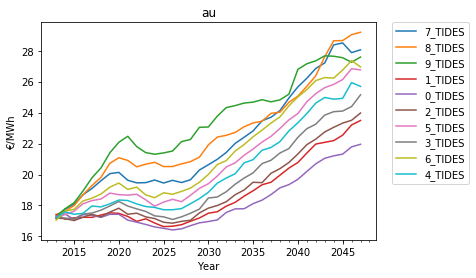

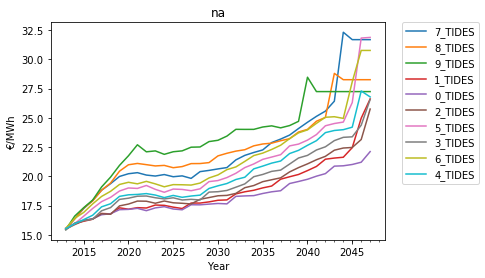

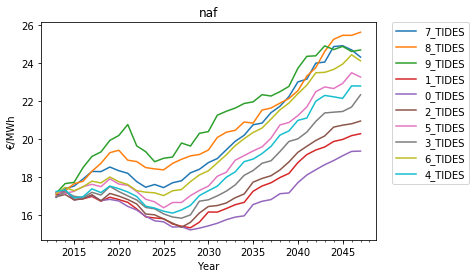

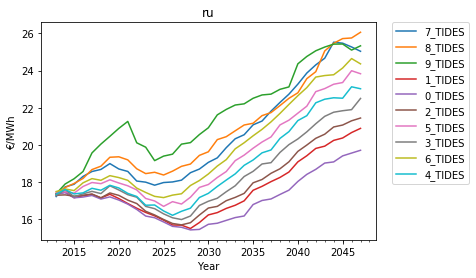

In [17]:
plt.subplots()
for market in init_market:
    for i in run_market:
        run_df = pd.DataFrame(run_market[i])
        run_df = run_df[run_df[3]==market]
        run_df.set_index(0, inplace=True)
        run_df.index = pd.to_datetime(run_df.index)
        run_df.index.name = 'month'
        run_df.rename(columns={1: 'price', 2: 'quantity'}, inplace=True)
        run_df = run_df['price'].resample('A').mean().plot(label=i, title=market)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel('€/MWh')
    plt.xlabel('Year')
    plt.show();

### saving data for later
To keep this file as clear as possible and for efficiency we visualize the results in a separate file. To transfer the model run data we use the Json library (and possibly excel).

In [18]:
today = datetime.date.today().strftime('%Y%m%d')
outputexcel = '.\exceloutput\%srun.xlsx' %today
writer = pd.ExcelWriter(outputexcel)

def write_to_excel():
    for i in run_market:
        run_df = pd.DataFrame(run_market[i])
        run_df.set_index(0, inplace=True)
        run_df.index = pd.to_datetime(run_df.index)
        run_df.index.name = 'month'
        run_df.rename(columns={1: 'price', 2: 'quantity'}, inplace=True)
        run_df.to_excel(writer, sheet_name=i)
# uncomment if wanted to write to excel file
#write_to_excel()


In [19]:
# Writing JSON data
# market data
data = run_market
with open('marketdata.json', 'w') as f:
     json.dump(data, f)

In [20]:
# seller/reserve data
data = run_seller
with open('sellerdata.json', 'w') as f:
     json.dump(data, f)

In [21]:
# buyer data
data = run_buyer
with open('buyerdata.json', 'w') as f:
     json.dump(data, f)

In [22]:
# complex dataframes do not work well with Json, so use Pickle
# Merge Dataframes
result = pd.concat([run_market_origin_df[i] for i in run_market_origin_df], axis=1)
#pickle does the job
result.to_pickle('marketdataorigin.pickle', compression='infer', protocol=4)

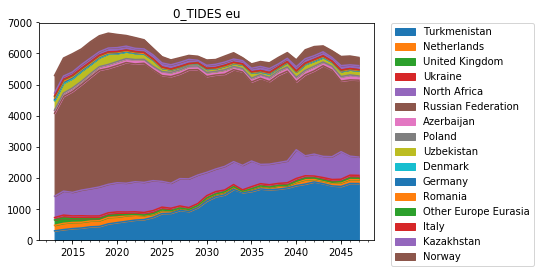

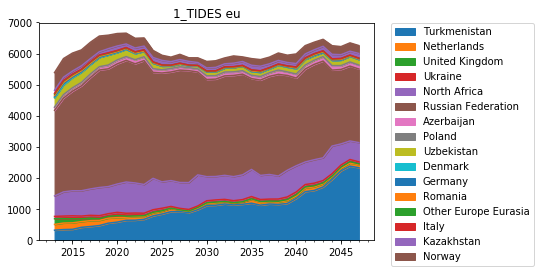

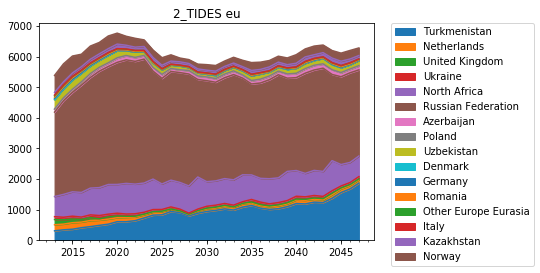

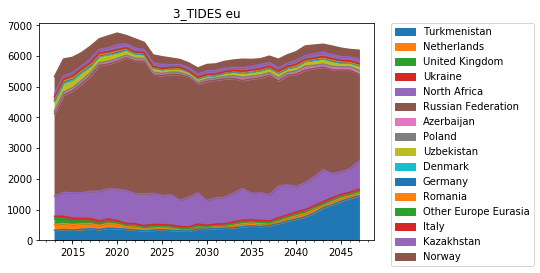

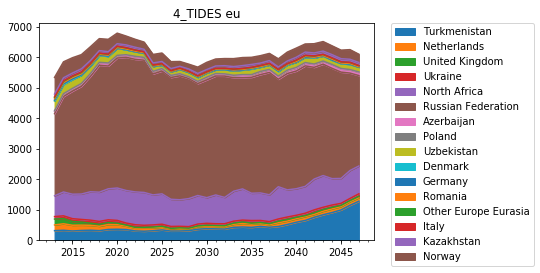

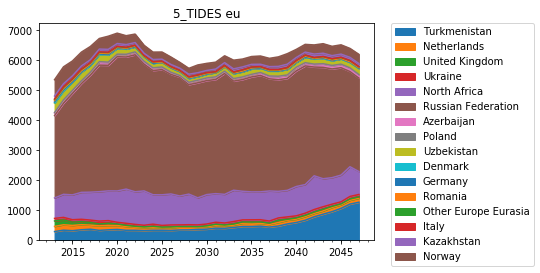

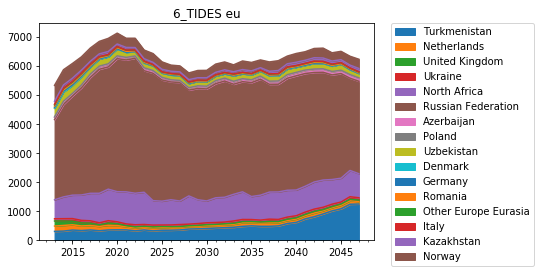

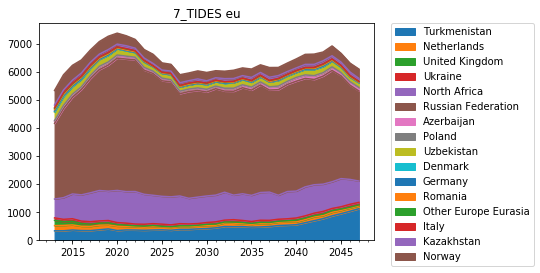

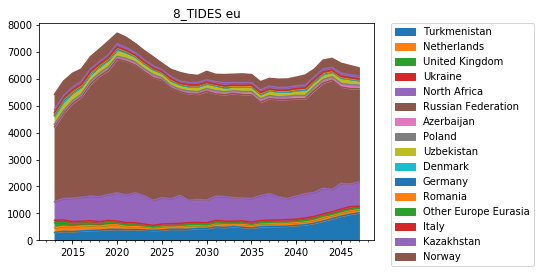

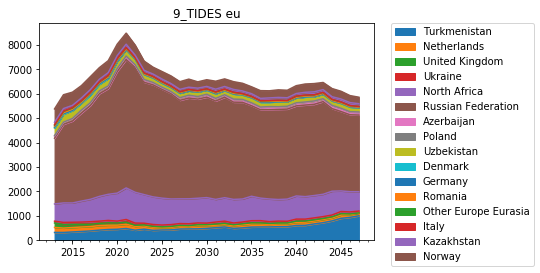

In [23]:
# testing if complex frames did what it is expected to do
df_pickle = result
for i in df_pickle.columns.levels[0]:
    scen=i
    market='eu'
    df = df_pickle[scen][market]['seller_analytics']
    df.index = pd.to_datetime(df.index)
    df.resample('A').sum().plot.area(title='%s %s'%(scen,market))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()